<a href="https://colab.research.google.com/github/wuyi010/AlexNet/blob/main/AlexNet_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AlexNet配置依赖项
1、torch.nn包中主要包含了用来搭建各个层的模块  （Modules），比如全连接、二维卷积、池化等；torch.nn包中还包含了一系列有用的loss函数，这些函数也是在训练神经网络时必不可少的，比如CrossEntropyLoss、MSELoss等；另外，torch.nn.functional子包中包含了常用的激活函数，如relu、leaky_relu、prelu、sigmoid等。

2、torch.optim包则主要包含了用来更新参数的优化算法，比如SGD、AdaGrad、RMSProp、 Adam等。https://zhuanlan.zhihu.com/p/208178763

In [ ]:
import time
import torch
from torch import nn, optim
import torchvision
import sys

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)   # cuda
print("sys.executable")
sys.executable   # /usr/bin/python3
# print("sys.modules")
# sys.modules    #注意区别sys.modules和sys.builtin_module_names——前者的关键字（keys）列出的是导入的模块名，而后者则是解释器内置的模块名。
# print("sys.builtin_module_names")
# sys.builtin_module_names


cpu
sys.executable


'/usr/bin/python3'

# AlexNet数据下载

In [ ]:

def load_data_fashion_mnist(batch_size, resize=None, root='~/Datasets/FashionMNIST'): # root：将数据保存在本地什么位置
    if sys.platform.startswith('win'):
        num_workers = 0
    else:            # 将num_workers分配给数据加载程序的准则 https://www.cnblogs.com/hesse-summer/p/11343870.html
        num_workers = 4 
    trans = []
    if resize:  # https://zhuanlan.zhihu.com/p/476220305
        trans.append(torchvision.transforms.Resize(size=resize))# transforms.Compose([transforms.Resize(resize),transforms.ToTensor(),])
    trans.append(torchvision.transforms.ToTensor()) # 转为Tensor类型

    transform = torchvision.transforms.Compose(trans)
      
    mnist_train = torchvision.datasets.FashionMNIST(root=root, train=True, download=True, transform=transform)
    mnist_test = torchvision.datasets.FashionMNIST(root=root, train=False, download=True, transform=transform)

    train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    #训练数据集的加载器，自动将数据分割成batch，顺序随机打乱
    test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)
              

    return train_iter, test_iter

batch_size = 128
train_iter, test_iter = load_data_fashion_mnist(batch_size, resize=224)

100%|██████████| 26421880/26421880 [00:02<00:00, 12021131.95it/s]


Extracting /root/Datasets/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/Datasets/FashionMNIST/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 201214.62it/s]


Extracting /root/Datasets/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/Datasets/FashionMNIST/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3712225.32it/s]


Extracting /root/Datasets/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/Datasets/FashionMNIST/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5501217.07it/s]

Extracting /root/Datasets/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/Datasets/FashionMNIST/FashionMNIST/raw




/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# AlexNet模型
https://blog.csdn.net/qq_27825451/article/details/90551513

```
class Sequential(Module):#继承Module  `
    def __init__(self, *args):  # 重写了构造函数
    def _get_item_by_idx(self, iterator, idx)：
    def __getitem__(self, idx):
    def __setitem__(self, idx, module):
    def __delitem__(self, idx):
    def __len__(self):
    def __dir__(self):
    def forward(self, input):  # 重写关键方法forward

```

卷积：输入是227x227x3，使用96个11x11x3的卷积核进行卷积，padding=0，stride=4，根据公式：(input_size + 2 * padding - kernel_size) / stride + 1=(227+2*0-11)/4+1=55，得到输出是55x55x96。
ReLU：将卷积层输出的FeatureMap输入到ReLU函数中
局部响应归一化：局部响应归一化层简称LRN，是在深度学习中提高准确度的技术方法。一般是在激活、池化后进行。LRN对局部神经元的活动创建竞争机制，使得其中响应比较大的值变得相对更大，并抑制其他反馈较小的神经元，增强了模型的泛化能力。

局部响应归一化的输出仍然是55x55x96。将其分成两组，每组大小是55x55x48，分别位于单个GPU上。

池化：使用3x3，stride=2的池化单元进行最大池化操作（max pooling）。注意这里使用的是重叠池化，即stride小于池化单元的边长。根据公式：(55+2*0-3)/2+1=27，每组得到的输出为27x27x48。

第二层：卷积：两组输入均是27x27x48，各组分别使用128个5x5x48的卷积核进行卷积，padding=2，stride=1，根据公式：(input_size + 2 * padding - kernel_size) / stride + 1=(27+2*2-5)/1+1=27，得到每组输出是27x27x128。

ReLU：将卷积层输出的FeatureMap输入到ReLU函数中。
局部响应归一化：使用参数k=2，n=5，α=0.0001，β=0.75进行归一化。每组输出仍然是27x27x128。
池化：使用3x3，stride=2的池化单元进行最大池化操作（max pooling）。注意这里使用的是重叠池化，即stride小于池化单元的边长。根据公式：(27+2*0-3)/2+1=13，每组得到的输出为13x13x128

第三层的处理流程是： 卷积-->ReLU
卷积：输入是13x13x256，使用384个3x3x256的卷积核进行卷积，padding=1，stride=1，根据公式：(input_size + 2 * padding - kernel_size) / stride + 1=(13+2*1-3)/1+1=13，得到输出是13x13x384。
ReLU：将卷积层输出的FeatureMap输入到ReLU函数中。将输出其分成两组，每组FeatureMap大小是13x13x192，分别位于单个GPU上。

C4：卷积：两组输入均是13x13x192，各组分别使用192个3x3x192的卷积核进行卷积，padding=1，stride=1，根据公式：(input_size + 2 * padding - kernel_size) / stride + 1=(13+2*1-3)/1+1=13，得到每组FeatureMap输出是13x13x192。

ReLU：将卷积层输出的FeatureMap输入到ReLU函数中。

该层的处理流程是：卷积-->ReLU-->池化

C5：卷积：两组输入均是13x13x192，各组分别使用128个3x3x192的卷积核进行卷积，padding=1，stride=1，根据公式：(input_size + 2 * padding - kernel_size) / stride + 1=(13+2*1-3)/1+1=13，得到每组FeatureMap输出是13x13x128。

ReLU：将卷积层输出的FeatureMap输入到ReLU函数中。

池化：使用3x3，stride=2的池化单元进行最大池化操作（max pooling）。注意这里使用的是重叠池化，即stride小于池化单元的边长。根据公式：(13+2*0-3)/2+1=6，每组得到的输出为6x6x128。

全连接层（FC6）:
该层的流程为：（卷积）全连接 -->ReLU-->Dropout （卷积）

全连接：输入为6×6×256，使用4096个6×6×256的卷积核进行卷积，由于卷积核尺寸与输入的尺寸完全相同，即卷积核中的每个系数只与输入尺寸的一个像素值相乘一一对应，根据公式：(input_size + 2 * padding - kernel_size) / stride + 1=(6+2*0-6)/1+1=1，得到输出是1x1x4096。既有4096个神经元，该层被称为全连接层。

ReLU：这4096个神经元的运算结果通过ReLU激活函数中。

Dropout：随机的断开全连接层某些神经元的连接，通过不激活某些神经元的方式防止过拟合。4096个神经元也被均分到两块GPU上进行运算。

全连接层（FC7）:
该层的流程为：（卷积）全连接 -->ReLU -->Dropout

全连接：输入为4096个神经元，输出也是4096个神经元（作者设定的）。

ReLU：这4096个神经元的运算结果通过ReLU激活函数中。

Dropout：随机的断开全连接层某些神经元的连接，通过不激活某些神经元的方式防止过拟合。

4096个神经元也被均分到两块GPU上进行运算。

输出层（Output layer）:
该层的流程为：（卷积）全连接 -->Softmax

全连接：输入为4096个神经元，输出是1000个神经元。这1000个神经元即对应1000个检测类别。

Softmax：这1000个神经元的运算结果通过Softmax函数中，输出1000个类别对应的预测概率值。

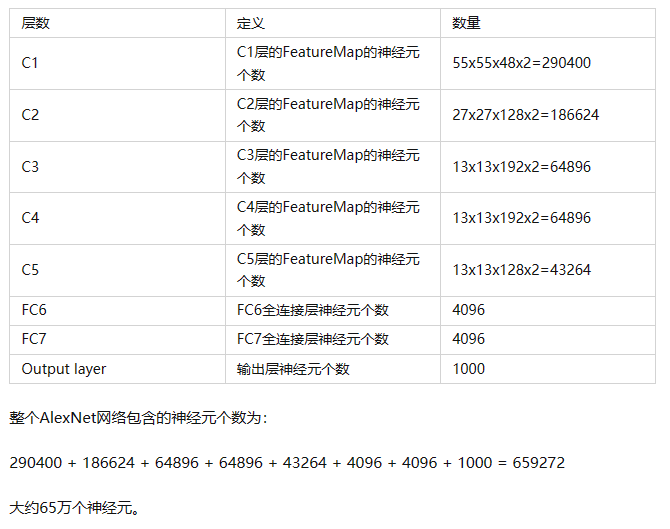

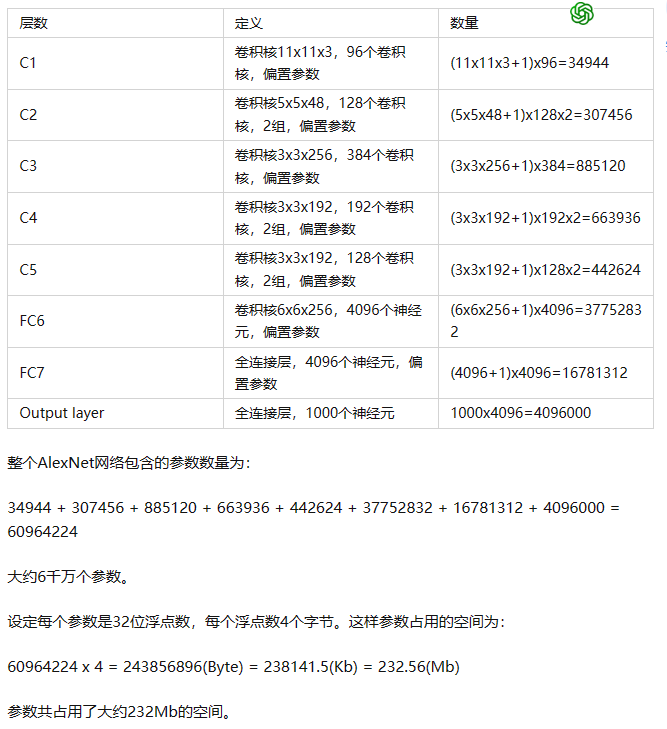

In [ ]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__() # 继承父类并使用父类初始化方法来初始化子类 
        self.conv = nn.Sequential(
            nn.Conv2d(1, 96, 11, 4), # in_channels, out_channels, kernel_size, stride, padding
            nn.ReLU(),
            nn.MaxPool2d(3, 2), # kernel_size, stride
            # 减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致，且增大输出通道数
            nn.Conv2d(96, 256, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(3, 2),
            # 连续3个卷积层，且使用更小的卷积窗口。除了最后的卷积层外，进一步增大了输出通道数。
            nn.Conv2d(256, 384, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(384, 384, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(384, 256, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(3, 2)
        )
        self.fc = nn.Sequential(
            nn.Linear(256*5*5, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 10),
        )

    def forward(self, img):
        feature = self.conv(img)
        output = self.fc(feature.view(img.shape[0], -1))
        return output

# AlexNet实例化

In [ ]:
net = AlexNet()
print(net)
print("---------------------------------------------------")
print(net.__dict__)

AlexNet(
  (conv): Sequential(
    (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=6400, out_features=4096, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=4096, out_features=4096, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (

# CrossEntropyLoss()函数

In [ ]:
#print(net.parameters())

Pytorch中CrossEntropyLoss()函数的主要是将softmax-log-NLLLoss合并到一块得到的结果。

1、Softmax后的数值都在0~1之间，所以ln之后值域是负无穷到0。

2、然后将Softmax之后的结果取log，将乘法改成加法减少计算量，同时保障函数的单调性。

3、NLLLoss的结果就是把上面的输出与Label对应的那个值拿出来(下面例子中就是：将log_output\logsoftmax_output中与y_target对应的值拿出来)，去掉负号，再求均值。下面是例子：https://zhuanlan.zhihu.com/p/98785902

In [ ]:
import torch
import torch.nn as nn
x_input=torch.randn(3,3)#随机生成输入 
y_target=torch.tensor([1,2,0])#设置输出具体值 print('y_target\n',y_target)
print('x_input:\n',x_input)
print('y_target:\n',y_target)
print("_______________________________________________________________________")

#计算输入softmax，此时可以看到每一行加到一起结果都是1
softmax_func=nn.Softmax(dim=1)
soft_output=softmax_func(x_input)
print('soft_output:\n',soft_output)

#在softmax的基础上取log
log_output=torch.log(soft_output)
print('log_output:\n',log_output)

#对比softmax与log的结合与nn.LogSoftmaxloss(负对数似然损失)的输出结果，发现两者是一致的。
logsoftmax_func=nn.LogSoftmax(dim=1)
logsoftmax_output=logsoftmax_func(x_input)
print('logsoftmax_output:\n',logsoftmax_output)

#pytorch中关于NLLLoss的默认参数配置为：reducetion=True、size_average=True
nllloss_func=nn.NLLLoss()
nlloss_output=nllloss_func(logsoftmax_output,y_target)
print('nlloss_output:\n',nlloss_output)

#直接使用pytorch中的loss_func=nn.CrossEntropyLoss()看与经过NLLLoss的计算是不是一样
crossentropyloss=nn.CrossEntropyLoss()
crossentropyloss_output=crossentropyloss(x_input,y_target)
print('crossentropyloss_output:\n',crossentropyloss_output)
#通过上面的结果可以看出，直接使用pytorch中的loss_func=nn.CrossEntropyLoss()
#计算得到的结果与softmax-log-NLLLoss计算得到的结果是一致的。

x_input:
 tensor([[ 0.9378,  0.3634,  0.8288],
        [ 0.7291, -0.8926,  1.6795],
        [-0.2302,  0.2431, -0.8890]])
y_target:
 tensor([1, 2, 0])
_______________________________________________________________________
soft_output:
 tensor([[0.4065, 0.2289, 0.3646],
        [0.2643, 0.0522, 0.6835],
        [0.3202, 0.5141, 0.1657]])
log_output:
 tensor([[-0.9001, -1.4745, -1.0090],
        [-1.3309, -2.9525, -0.3805],
        [-1.1388, -0.6654, -1.7976]])
logsoftmax_output:
 tensor([[-0.9001, -1.4745, -1.0090],
        [-1.3309, -2.9525, -0.3805],
        [-1.1388, -0.6654, -1.7976]])
nlloss_output:
 tensor(0.9979)
crossentropyloss_output:
 tensor(0.9979)


# AlexNet准确率评估

In [ ]:
# data_iter = test_iter
def evaluate_accuracy(data_iter, net, device=None):
    if device is None and isinstance(net, torch.nn.Module):
        # 如果没指定device就使用net的device
        device = list(net.parameters())[0].device
    acc_sum, n = 0.0, 0
    with torch.no_grad():
        for X, y in data_iter:
            net.eval() # 评估模式, 这会关闭dropout
            acc_sum += (net(X.to(device)).argmax(dim=1) == y.to(device)).float().sum().cpu().item()
            net.train() # 改回训练模式
            n += y.shape[0] #行数
    return acc_sum / n

# AlexNet模型训练

多个GPU指定计算资源
```
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
model = Model() 
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model，device_ids=[0,1,2])   
    model.to(device)
```

CrossEntropyLoss:交叉熵是信息论中的一个重要概念，主要用于度量两个概率分布间的差异性——判定实际的输出与期望的输出的接近程度

In [ ]:
def train(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs):
    net = net.to(device) #显示指定需要使用的计算资源:读取数据的tensor变量copy一份到device所指定的GPU上去
    print("training on ", device)
    loss = torch.nn.CrossEntropyLoss() #交叉熵损失函数
    for epoch in range(num_epochs):
        train_lossVal_sum, train_acc_sum, n, batch_count, start = 0.0, 0.0, 0, 0, time.time()
        for X, y in train_iter:
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            lossValue = loss(y_hat, y)
            optimizer.zero_grad()  #清空过往梯度
            lossValue.backward()  #反向传播，计算当前梯度
            optimizer.step()    #根据梯度更新网络参数
            train_lossVal_sum += lossValue.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item() #https://blog.csdn.net/AMBE_R_/article/details/115512034
            n += y.shape[0]
            batch_count += 1

        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec' % (epoch+1,train_lossVal_sum / batch_count, train_acc_sum / n, test_acc, time.time() - start))
        print('batch_count:%d, y.shape[0]:%d, batch_count:%d' %(batch_count,y.shape[0],batch_count))
        

# main

In [ ]:
lr, num_epochs = 0.001, 5
optimizer = torch.optim.Adam(net.parameters(), lr=lr) #优化器
train(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs)

training on  cpu


# AlexNet结果
epoch 1, loss 0.0706, train acc 0.979, test acc 0.919, time 57.4 sec

epoch 2, loss 0.0730, train acc 0.979, test acc 0.910, time 57.7 sec

epoch 3, loss 0.0685, train acc 0.979, test acc 0.916, time 57.5 sec

epoch 4, loss 0.0882, train acc 0.975, test acc 0.914, time 57.3 sec

epoch 5, loss 0.0644, train acc 0.981, test acc 0.916, time 58.4 sec

epoch 6, loss 0.0561, train acc 0.983, test acc 0.916, time 57.2 sec

epoch 7, loss 0.0654, train acc 0.980, test acc 0.913, time 58.5 sec

epoch 8, loss 0.0704, train acc 0.979, test acc 0.914, time 57.1 sec

epoch 9, loss 0.0568, train acc 0.983, test acc 0.918, time 58.3 sec

epoch 10, loss 0.0614, train acc 0.982, test acc 0.915, time 57.1 sec